### Test the trained VPTR

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

from pathlib import Path
import random
from datetime import datetime
import time

from model import VPTREnc, VPTRDec, VPTRDisc, init_weights, VPTRFormerFAR, VPTRFormerNAR
from model import GDL, MSELoss, L1Loss, GANLoss
from utils import KTHDataset, BAIRDataset, MovingMNISTDataset
from utils import VidCenterCrop, VidPad, VidResize, VidNormalize, VidReNormalize, VidCrop, VidRandomHorizontalFlip, VidRandomVerticalFlip, VidToTensor
from utils import visualize_batch_clips, save_ckpt, load_ckpt, set_seed, AverageMeters, init_loss_dict, write_summary, resume_training, write_code_files
from utils import set_seed, PSNR, SSIM, MSEScore, get_dataloader
import lpips
import numpy as np


from matplotlib import pyplot as plt

from models import IJEPA_base, CustomDataParallel, EarlyStop
import os

set_seed(2021)

/Users/GIacomoBugli/opt/anaconda3/envs/dl_project/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("mps")

In [3]:
# resume_ckpt = Path('../output/test_VPTR/epoch_22.tar') #The trained Transformer checkpoint file
resume_ckpt = None
resume_AE_ckpt = Path('../output/test_VPTR/epoch_4.tar') #The trained AutoEncoder checkpoint file
num_past_frames = 11
num_future_frames = 11
encH, encW, encC = 6, 6, 528
TSLMA_flag = False
rpe = True
model_flag = 'FAR' #'NAR' for NAR model, 'FAR' for FAR model

img_channels = 3 # 1 for KTH and MovingMNIST, 3 for BAIR
N = 1
loss_name_list = ['T_MSE', 'T_GDL', 'T_gan', 'T_total', 'Dtotal', 'Dfake', 'Dreal']

In [4]:
#Set the padding_type to be "zero" for BAIR dataset
VPTR_Enc = VPTREnc(img_channels, feat_dim = encC, n_downsampling = 3).to(device)
VPTR_Dec = VPTRDec(img_channels, feat_dim = encC, n_downsampling = 3, out_layer = 'Tanh').to(device)
VPTR_Enc = VPTR_Enc.eval()
VPTR_Dec = VPTR_Dec.eval()

if model_flag == 'NAR':
    VPTR_Transformer = VPTRFormerNAR(num_past_frames, num_future_frames, encH=encH, encW = encW, d_model=encC, 
                                         nhead=8, num_encoder_layers=4, num_decoder_layers=8, dropout=0.1, 
                                         window_size=4, Spatial_FFN_hidden_ratio=4, TSLMA_flag = TSLMA_flag, rpe=rpe).to(device)
else:
    VPTR_Transformer = VPTRFormerFAR(num_past_frames, num_future_frames, encH=encH, encW = encW, d_model=encC, 
                                    nhead=8, num_encoder_layers=6, dropout=0.1, 
                                    window_size=4, Spatial_FFN_hidden_ratio=4, rpe=rpe).to(device)

VPTR_Transformer = VPTR_Transformer.eval()

#load the trained autoencoder, we initialize the discriminator from scratch, for a balanced training
loss_dict, start_epoch = resume_training({'VPTR_Enc': VPTR_Enc, 'VPTR_Dec': VPTR_Dec}, {}, resume_AE_ckpt, loss_name_list, map_location=device)
if resume_ckpt is not None:
    loss_dict, start_epoch = resume_training({'VPTR_Transformer': VPTR_Transformer}, 
                                             {}, resume_ckpt, loss_name_list, map_location=device)

/Users/GIacomoBugli/opt/anaconda3/envs/dl_project/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
_, _, test_loader, renorm_transform = get_dataloader('BAIR', N, '/Users/GIacomoBugli/Desktop/NYU/CLASSES/Second-Year/1008-Deep Learning/Project/Dataset/Dataset_Student/train', '/Users/GIacomoBugli/Desktop/NYU/CLASSES/Second-Year/1008-Deep Learning/Project/Dataset/Dataset_Student/val', test_past_frames = 11, 
                                                     test_future_frames = 11, ngpus = 1, num_workers = 1)

In [6]:
def plot_model_result(pred, fig_name, num_frames, n = 2):
    """
    Plot and save figure
    """
    fig, ax = plt.subplots(1, num_frames, figsize = (num_frames, 1))
    fig.subplots_adjust(wspace=0., hspace = 0.)

    for j in range(num_frames):
        ax[j].set_axis_off()
        
        img = pred[:, j, :, :, :].clone()
        img = renorm_transform(img)
        img = torch.clamp(img, min = 0., max = 1.)
        img = img[n, ...]

        img = transforms.ToPILImage()(img)
        ax[j].imshow(img)
    # fig.savefig(f'{fig_name}.pdf', bbox_inches = 'tight')
    
def FAR_RIL_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device):
    """
    recurrently inference over Latent space, get a worse result
    """
    past_frames, future_frames = sample
    past_frames = past_frames.to(device)
    future_frames = future_frames.to(device)
    assert num_pred == future_frames.shape[1], "Mismatch between ground truth future frames length and num_pred"

    past_gt_feats = VPTR_Enc(past_frames)
    pred_feats = VPTR_Transformer(past_gt_feats)
    
    pred_frames = VPTR_Dec(pred_feats[:, -1:, ...])
    for i in range(1, num_pred):
        if i == 1:
            input_feats = torch.cat([past_gt_feats, pred_feats[:, -1:, ...]], dim = 1)
        elif i < VPTR_Transformer.num_future_frames:
            input_feats = torch.cat([input_feats, pred_future_feat], dim = 1)
        else:
            input_feats = torch.cat([input_feats, pred_future_feat], dim = 1)
            input_feats = input_feats[:, 1:, ...]
        
        pred_feats = VPTR_Transformer(input_feats)
        pred_future_frame = VPTR_Dec(pred_feats[:, -1:, ...])
        pred_future_feat = pred_feats[:, -1:, ...]
        pred_frames = torch.cat([pred_frames, pred_future_frame], dim = 1)
    
    return pred_frames, future_frames

def FAR_RIP_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device):
    """
    recurrently inference over pixel space
    """
    past_frames, future_frames = sample
    past_frames = past_frames.to(device)
    future_frames = future_frames.to(device)
    assert num_pred == future_frames.shape[1], "Mismatch between ground truth future frames length and num_pred"

    past_gt_feats = VPTR_Enc(past_frames)
    pred_feats = VPTR_Transformer(past_gt_feats)
    
    pred_frames = VPTR_Dec(pred_feats[:, -1:, ...])
    for i in range(1, num_pred):
        if i == 1:
            input_feats = torch.cat([past_gt_feats, pred_feats[:, -1:, ...]], dim = 1)
        elif i < VPTR_Transformer.num_future_frames:
            input_feats = torch.cat([input_feats, pred_future_feat], dim = 1)
        else:
            input_feats = torch.cat([input_feats, pred_future_feat], dim = 1)
            input_feats = input_feats[:, 1:, ...]
        
        pred_feats = VPTR_Transformer(input_feats)
        pred_future_frame = VPTR_Dec(pred_feats[:, -1:, ...])
        pred_future_feat = VPTR_Enc(pred_future_frame)
        pred_frames = torch.cat([pred_frames, pred_future_frame], dim = 1)
    
    return pred_frames, future_frames

def NAR_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device):
    """
    NAR model inference function, for the case num_pred is divisible for the num_future_frames of training. e.g. num_pred = 20, num_future_frames = 10
    """
    past_frames, future_frames = sample
    past_frames = past_frames.to(device)
    future_frames = future_frames.to(device)
    assert num_pred == future_frames.shape[1], "Mismatch between ground truth future frames length and num_pred"
    assert num_pred % VPTR_Transformer.num_future_frames == 0, "Mismatch of num_pred and trained Transformer"
    
    past_gt_feats = VPTR_Enc(past_frames)
    
    for i in range(0, num_pred//VPTR_Transformer.num_future_frames):
        pred_future_feats = VPTR_Transformer(past_gt_feats)
        if i == 0:
            pred_frames = VPTR_Dec(pred_future_feats)
        else:
            pred_frames = torch.cat([pred_frames, VPTR_Dec(pred_future_feats)], dim = 1)
        past_gt_feats = pred_future_feats
        
    
    return pred_frames, future_frames


def NAR_BAIR_2_to_28_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device):
    """
    Specifically for BAIR dataset, 2 -> 28 prediction.
    """
    past_frames, future_frames = sample
    past_frames = past_frames.to(device)
    future_frames = future_frames.to(device)
    assert num_pred == future_frames.shape[1], "Mismatch between ground truth future frames length and num_pred"
    #assert num_pred % VPTR_Transformer.num_future_frames == 0, "Mismatch of num_pred and trained Transformer"
    
    pred = []
    #prediction 1
    past_gt_feats = VPTR_Enc(past_frames)
    pred_future_feats = VPTR_Transformer(past_gt_feats)
    pred_frames = VPTR_Dec(pred_future_feats)
    pred.append(pred_frames)
    #prediction 2
    past_frames = pred_frames[:, -2:, ...]
    past_gt_feats = VPTR_Enc(past_frames)
    pred_future_feats = VPTR_Transformer(past_gt_feats)
    pred_frames = VPTR_Dec(pred_future_feats)
    pred.append(pred_frames)
    
    #prediction 3
    past_frames = pred_frames[:, -2:, ...]
    past_gt_feats = VPTR_Enc(past_frames)
    pred_future_feats = VPTR_Transformer(past_gt_feats)
    pred_frames = VPTR_Dec(pred_future_feats)
    pred.append(pred_frames[:, 0:-2, ...])
    pred_frames = torch.cat(pred, dim = 1)
    
    return pred_frames, future_frames         

In [7]:
sample = next(iter(test_loader))
num_pred = 11
with torch.no_grad():
    pred_frames, gt_frames = FAR_RIL_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device)


KeyboardInterrupt: 

In [8]:
sample = next(iter(test_loader))

In [9]:
repr = VPTR_Enc(sample[0].to(device))
repr.shape

torch.Size([2, 11, 528, 20, 30])

In [10]:
repr_transformer = VPTR_Transformer(repr)
repr_transformer.shape

KeyboardInterrupt: 

In [14]:
torch.mps.empty_cache()

In [15]:
dec = VPTR_Dec(repr_transformer)
dec.shape

torch.Size([2, 11, 3, 160, 240])

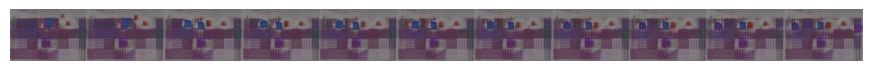

In [16]:
plot_model_result(dec, 'pred_nar', 11, n = 1)

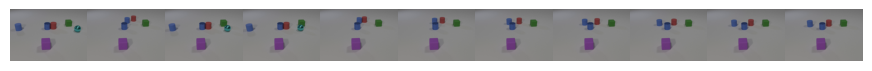

In [17]:
plot_model_result(sample[1], 'actual', 11, n=1)

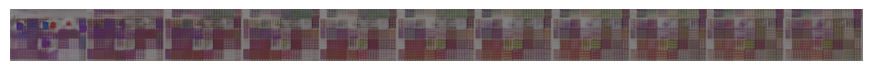

In [18]:
plot_model_result(pred_frames, 'pred_nar', 11, n = 1)

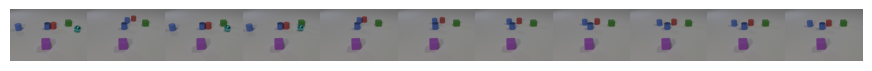

In [19]:
plot_model_result(gt_frames, 'gt_mnist', 11, n = 1)

In [7]:
jepa = IJEPA_base(img_size=128, patch_size=16, in_chans=3, norm_layer=nn.LayerNorm, num_frames=22, attention_type='joint_space_time', dropout=0.01, mode="test", r=0.5, embed_dim=528, device=device, skip_patch=True,
                        # encoder parameters
                        enc_depth=4,
                        enc_num_heads=6,
                        enc_mlp_ratio=4.,
                        enc_qkv_bias=False,
                        enc_qk_scale=None,
                        enc_drop_rate=0.,
                        enc_attn_drop_rate=0.,
                        enc_drop_path_rate=0.1,
                        # predictor parameters
                        pred_depth=4,
                        pred_num_heads=6,
                        pred_mlp_ratio=4.,
                        pred_qkv_bias=False,
                        pred_qk_scale=None,
                        pred_drop_rate=0.1,
                        pred_attn_drop_rate=0.1,
                        pred_drop_path_rate=0.1,
                        # positional and spacial embedding parameters
                        pos_drop_rate=0.1,
                        time_drop_rate=0.1)
    # Leave this to load properly the optimizer dict
jepa.to(device)

IJEPA_base(
  (norm): LayerNorm((528,), eps=1e-05, elementwise_affine=True)
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 528, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (time_drop): Dropout(p=0.1, inplace=False)
  (teacher_encoder): VisionTransformer(
    (dropout): Dropout(p=0.01, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((528,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=528, out_features=1584, bias=False)
          (proj): Linear(in_features=528, out_features=528, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((528,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=528, out_features=2112, bias=True)
          (act): GELU(approximate='none')
          (fc

In [8]:
jepa_chk = Path('../output/test_VPTR')
model_dict = torch.load(os.path.join(jepa_chk, "best_model.pkl"), map_location=device)
jepa.load_state_dict(model_dict)

<All keys matched successfully>

In [9]:
sample = next(iter(test_loader))

In [27]:
sample[0].shape

torch.Size([1, 11, 3, 160, 240])

In [18]:
repr = VPTR_Enc(sample[0].to(device))
repr.shape

torch.Size([1, 11, 528, 20, 30])

In [19]:
from einops import rearrange

In [20]:
repr = rearrange(repr, 'b t n h w -> b n (t h w)')
repr = F.interpolate(repr, (704))
repr = rearrange(repr, 'b m n -> b n m')
repr.shape

torch.Size([1, 704, 528])

In [21]:
emb_jepa = jepa(repr)

In [22]:
emb_jepa = rearrange(emb_jepa, 'b n m -> b m n')
emb_jepa = F.interpolate(emb_jepa, (6600))
emb_jepa = rearrange(emb_jepa, 'b n (t h w) -> b t n h w', t=11, h=20)
emb_jepa.shape

torch.Size([1, 11, 528, 20, 30])

In [23]:
dec = VPTR_Dec(emb_jepa)
dec.shape

torch.Size([1, 11, 3, 160, 240])

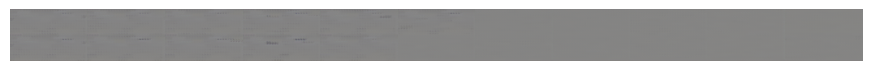

In [25]:
plot_model_result(dec, 'pred_nar', 11, n = 0)

In [ ]:
import numpy as np
from utils import PSNR, SSIM
import lpips

def pred_ave_metrics(model, data_loader, metric_func, renorm_transform, num_future_frames, num_past_frames, device = 'cuda:0', use_lpips = False, gray_scale = True):
    model = model.to(device)
    model = model.eval()
    ave_metric = np.zeros(num_future_frames)
    sample_num = 0

    with torch.no_grad():
        for idx, sample in enumerate(data_loader, 0):
            past_frames, future_frames = sample
            past_frames = past_frames.to(device)
            future_frames = future_frames.to(device)
            pred = model(past_frames)
            for i in range(0, num_future_frames):
                pred_t = pred[:, i, ...]
                future_frames_t = future_frames[:, i, ...]
                
                if not use_lpips:
                    pred_t = renorm_transform(pred_t)
                    future_frames_t = renorm_transform(future_frames_t)
                elif use_lpips and gray_scale:
                    pred_t = pred_t.repeat(1, 3, 1, 1)
                    future_frames_t = future_frames_t.repeat(1, 3, 1, 1)
                    
                m = metric_func(pred_t, future_frames_t)*pred_t.shape[0]
                try:
                    ave_metric[i] += m.mean()
                except AttributeError:
                    ave_metric[i] += m
                
            sample_num += pred.shape[0]

    ave_metric = ave_metric / sample_num
    return ave_metric

In [28]:
import os
import gc
import torch
import torch.nn as nn
import torch.nn.utils as utils
from einops import rearrange
import time
# import imageio.v3 as iio
import numpy as np
import copy
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import math
import torch.nn.functional as F
import warnings
from video_dataset import VideoFrameDataset, ImglistToTensor

In [37]:
preprocess = transforms.Compose([
        ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        # transforms.Resize(299),  # image batch, resize smaller edge to 299
        transforms.Resize((128,128)),
        # transforms.CenterCrop(299),  # image batch, center crop to square 299x299
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

dataset = VideoFrameDataset(
    root_path='/Users/GIacomoBugli/Desktop/NYU/CLASSES/Second-Year/1008-Deep Learning/Project/Dataset/Dataset_Student/train/data',
    annotationfile_path='/Users/GIacomoBugli/Desktop/NYU/CLASSES/Second-Year/1008-Deep Learning/Project/Dataset/Dataset_Student/train/annotations.txt',
    num_segments=1,
    frames_per_segment=22,
    imagefile_template='image_{:d}.png',
    transform=preprocess,
    test_mode=False,
    mask=True
)

dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=2,
        shuffle=True,
        num_workers=12,
        pin_memory=True
    )

/Users/GIacomoBugli/opt/anaconda3/envs/dl_project/lib/python3.9/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [38]:
data, labels, masks = next(iter(dataloader))

/Users/GIacomoBugli/opt/anaconda3/envs/dl_project/lib/python3.9/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/Users/GIacomoBugli/opt/anaconda3/envs/dl_project/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=Non

In [39]:
masks.shape

torch.Size([2, 22, 160, 240])